## Python для сбора и анализа данных

*Алла Тамбовцева, НИУ ВШЭ*

### Управление браузером с Selenium: пример Кинопоиска

Библиотека Selenium – библиотека для управления браузером с помощью Python. Она позволяет запускать браузер и имитировать действия пользователя в нем. Зачем это может понадобиться? Во-первых, такое «встраивание» в браузер в большинстве случаев позволяет решить проблему с возникающими капчами и иными ограничениями, так как настройки сайта не распознают, что запрос к исходному коду страницы производится автоматически. Во-вторых, необходимость имитации действий в браузере неизбежно возникает при обработке динамических веб-страниц, где некоторые элементы (окна, графики, таблицы) появляются только при определенных действиях пользователя, например, при скроллинге или наведении мышкой. В-третьих, библиотека может быть полезна в случаях, если доступ к API сайта или базы данных получить довольно сложно, но при работе в браузере информация доступна (в таком случае можем залогиниться через Python как будто пользователь и потихоньку выгружать данные).

Установим библиотеку:

In [ ]:
# устанавливаем selenium

!pip install selenium

Импортируем необходимые компоненты Selenium:

In [1]:
# импортируем модуль wd для открытия браузера
# By – коллекция методов для поиска элементов
# Keys – коллекция для имитации нажатия клавиш на клавиатуре

from selenium import webdriver as wd
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

Заодно импортируем `BeautifulSoup`, понадобится, когда дойдем до исходного кода:

In [2]:
from bs4 import BeautifulSoup

Открываем браузер – начинаем новую сессию работы с Selenium (скачиваем драйвер для Chrome, см. [инструкцию](https://github.com/allatambov/WebScrape23/blob/main/selenium.pdf)), после запуска кода должно открыться новое окно браузера, пустое:

In [3]:
br = wd.Chrome(executable_path="/Users/allat/Documents/chromedriver")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  """Entry point for launching an IPython kernel.


Отправляем запрос – открываем главную страницу Кинопоиска в новом окне браузера:

In [4]:
# чудеса вышкинского вайфая – капча не вылезает
# если вылезла – проходим ее вручную, тыкаем на галочку и вводим текст

br.get("https://www.kinopoisk.ru/")

Почти со 100% уверенностью Кинопоиск покажет капчу, мы поступим не самым спортивным, но бесплатным способом – вручную пройдем ее в открытом через Selenium окне браузера. Вообще самый надежный и универсальный способ обхода – установить специальное расширение и получить доступ к сервисам типа AntiCapcha или Antigate, а потом активировать это расширение при открытии браузера через Selenium. Но эти сервисы платные, хоть и не очень дорогие. 

В нашем случае проблема с капчей не такая уж и глобальная, если мы пишем код для себя. Если мы все-таки пишем код для другого пользователя или вообще готовим какое-то приложение, тут есть о чем подумать еще помимо капчи, например, о том, как пользователям безболезненно установить все для Selenium или как разместить драйвер для Chrome (и сам Chrome) на сервере...

Ищем на странице поле для поиска фильма, судя по его виду (проверить можно, открыв исходный код страницы), оно будет иметь тэг `<input>`:

In [5]:
# ищем на странице поле для поиска фильма
# find_elements – все элементы в виде списка
# тут такой один

br.find_elements(By.TAG_NAME, "input")

[<selenium.webdriver.remote.webelement.WebElement (session="71c6e8b5f201596779921459a1a8b3c8", element="688321c8-8edf-4269-ab19-8689ae504d42")>]

Метод `.find_elements()` возвращает все элементы, удовлетворяющие критериям поиска, в виде списка. В данном случае результат точно один, поэтому изменим метод на `.find_element()`, чтобы не извлекать элемент из списка по индексу. Метод `.find_element()` всегда возвращает один результат, если подходящих фрагментов несколько, забирается только первое совпадение.

In [6]:
search = br.find_element(By.TAG_NAME, "input")

Теперь нам надо в это поле впечатать название фильма. Сделать это можно с помощью метода `.send_keys()`, он используется для заполнения полей (и иногда для выбора опций в выпадающем меню).

In [7]:
film = "Господин оформитель"
search.send_keys(film)

Если проверить, в окне браузера в строке поиска должно появиться название фильма. Чтобы активировать поиск, надо выбрать в выпадающем меню подходящее название и кликнуть на него. Но мы поступим проще – имитируем нажатие *Enter* через набор клавишей `Keys` и тот же метод `.send_keys()`:

In [8]:
search.send_keys(Keys.ENTER)

Отлично! Результаты появились. Единственный минус – фильм не один. Найдем тот, который нам нужен, по частичному совпадению текста ссылки (ссылки на фильмы содержат сами ссылки в виде адресов и текст):

In [9]:
# результат не один – ищем подходящую ссылку
# по совпадению текста ссылки с film

link = br.find_element(By.PARTIAL_LINK_TEXT, film)

Объект найден, кликаем на него:

In [10]:
link.click()

Страница фильма открыта. Заберем исходный код страницы, открытой в браузере в данный момент:

In [11]:
html = br.page_source

Переменная `html` хранит обычную строку с кодом HTML. Преобразуем ее в объект BeautifulSoup, чтобы далее, как обычно, выполнять поиск по тэгам.

In [12]:
soup = BeautifulSoup(html)

С поиском информации по тэгам мы уже довольно много работали, поэтому давайте для примера найдем раздел с описанием фильма и на этом остановимся:

In [13]:
tab = soup.find("div", {"data-test-id" : "encyclopedic-table"})

Внутри этого раздела можно найти все подразделы с тэгом `div`, а затем из каждого извлечь текст (не очень красиво, но задача у этого практикума немного другая – сейчас перейдем к более интересным данным):

In [14]:
# некрасиво, но пока для примера

divs = tab.find_all("div")
texts = [d.text for d in divs]
texts

['Год производства1988',
 'Год производства',
 '1988',
 'СтранаСССР',
 'Страна',
 'СССР',
 'Жанружасы, фэнтези, драма, детективслова',
 'Жанр',
 'ужасы, фэнтези, драма, детективслова',
 'ужасы, фэнтези, драма, детектив',
 'Слоган—',
 'Слоган',
 '—',
 '—',
 'РежиссерОлег Тепцов',
 'Режиссер',
 'Олег Тепцов',
 'СценарийЮрий Арабов, Александр Грин',
 'Сценарий',
 'Юрий Арабов, Александр Грин',
 'Директор фильмаОлег Тепцов, Вениамин Кутиков',
 'Директор фильма',
 'Олег Тепцов, Вениамин Кутиков',
 'ОператорАнатолий Лапшов',
 'Оператор',
 'Анатолий Лапшов',
 'КомпозиторСергей Курехин',
 'Композитор',
 'Сергей Курехин',
 'ХудожникНаталья Васильева, Лариса Конникова',
 'Художник',
 'Наталья Васильева, Лариса Конникова',
 'МонтажИрина Гороховская',
 'Монтаж',
 'Ирина Гороховская',
 'Зрители3.3 млн , ...',
 'Зрители',
 '3.3 млн , ...',
 'Премьера в мире18 мая 1990, ...',
 'Премьера в мире',
 '18 мая 1990, ...',
 'Возраст16+',
 'Возраст',
 '16+',
 'Время109 мин. / 01:49',
 'Время',
 '109 мин. / 0

Информация выгружена, при желании из `tab` элементы можно извлечь более аккуратно, уточнив атрибуты тэгов `div`, а мы перейдем к более глобальной задаче. Давайте получим данные, на основе которых на сайте строятся графики, визуализирующие распределение оценок фильмов. Для этого сначала найдем ссылку, которую ведет на страницу с оценками. Если изучить исходный код страницы, можно заметить, что эта ссылка, как и все ссылки, имеет тэг `<a>`, но отличается тем, что имеет атрибут `class` со значением `film-rating-value styles_rootLink__mm0kW`. Для разнообразия найдем ссылку с помощью XPATH:

In [15]:
# ищем и кликаем

rating = br.find_element(By.XPATH, 
                         "//a[@class = 'film-rating-value styles_rootLink__mm0kW']")
rating.click()

Небольшое отступление – что такое XPATH и зачем.

**XPATH** (от *XML Path Language*) – язык запросов в XML-файлу, который можно использовать и для HTML тоже.

**XML** (от *eXtended MarkUp Language*) – язык разметки, только в отличие от HTML не позволяет регулировать внешний вид страницы, а просто хранит данные в виде строки с удобными тэгами.

На XML-файл можно смотреть как на хранилище, откуда по запросу динамически подгружаются данные для подстановки в HTML-файл. Смысл: когда нам нужно постоянно обновлять информацию на веб-странице (каталоги товаров в магазине, данные о погоде, курсе валют), не нужно каждый раз переписывать HTML-файл, достаточно изменить XML-файл, а из него уже информация «подтянется» на страницу с помощью запроса, написанного на JavaScript.

Примеры запросов с XPATH (честно взяты [отсюда](https://www.w3schools.com/xml/xpath_intro.asp), очень полезный тьюториал по XPATH, у них же есть классные материалы по XML):

* `//title[@lang]`: все элементы с тэгом `<title>`, имеющие атрибут `lang`;
* `//title[@lang='en']` : все элементы с тэгом `<title>`, имеющие атрибут `lang`, равный `'en'`;
* `//title[@*]`: все элементы с тэгом `<title>`, имеющие хоть какие-нибудь атрибуты.

Возвращаемся к странице на Кинопоиске. В браузере открыта страница с оценками фильма. Давайте снова сгрузим исходный код HTML и найдем в нем фрагмент, содержащий ссылку на данные, на основе которых строится круговая диаграмма.

In [16]:
# снова забираем исходный код страницы
# преобразуем

htm = br.page_source
sou = BeautifulSoup(htm)

Если внимательно изучим исходный код страницы, заметим, что ссылка на нужные данные хранится во фрагменте кода на JavaScript. Найдем его и заберем весь текст оттуда (атрибут `.text`):

In [17]:
code = sou.find_all("script", {"type" : "text/javascript"})[12].text
code

"\n$(function () {\n    $('#flashcontent_2').css({\n        marginTop: 20,\n        width: 500,\n        height: 330,\n    });\n    KPChart.create({\n        containerId: 'flashcontent_2',\n        chartType: 'pie',\n        dataURI: 'https://kinopoisk-fvs.s3.yandex.net/films/44587/value-stats.json',\n        dataType: 'json',\n        pie: {\n            minRadius: 110,\n            innerRadius: 25,\n            depth3D: 20,\n            angle: 25,\n            labelRadius: 30,\n            startDuration: 0,\n            pulledField: 'out',\n            hideLabelsPercent: 3,\n            descriptionField: null,\n            colors: [\n                '#FF0F00',\n                '#FF6600',\n                '#FF9E01',\n                '#FCD202',\n                '#F8FF01',\n                '#B0DE09',\n                '#04D215',\n                '#0D8ECF',\n                '#0D52D1',\n                '#2A0CD0'\n            ]\n        },\n        legend: {\n            position: 'absolute

В переменной `code` хранится обычная строка, объект типа `string`. Так это не блок кода HTML, поиск по тэгам здесь невозможен. Воспользуемся регулярными выражениями – найдем все ссылки, который заканчиваются на `.json`:

In [18]:
import re

# начало и конец ссылки известны

data_link = re.findall("https:.+\.json", code)[0]
data_link

'https://kinopoisk-fvs.s3.yandex.net/films/44587/value-stats.json'

Ура, ссылка найдена! Отправляем ее в браузер, окно которого у нас все еще открыто, благодаря Selenium, и снова забираем исходный код (уже последний раз). 

In [19]:
br.get(data_link)
page = br.page_source

В данном случае проще не преобразовывать исходный код в объект BeautifulSoup, поэтому с помощью регулярных выражений найдем фрагмент, который содержит данные в формате JSON-строки (как будто список со словарями):

In [20]:
# как список словарей, только в тексте

data_str = re.findall("\[\{.+\}\]", page)[0]
data_str

'[{"value":241,"title":"1","out":null},{"value":140,"title":"2","out":null},{"value":211,"title":"3","out":null},{"value":305,"title":"4","out":null},{"value":730,"title":"5","out":null},{"value":1262,"title":"6","out":null},{"value":2202,"title":"7","out":"true"},{"value":2130,"title":"8","out":null},{"value":1136,"title":"9","out":null},{"value":1638,"title":"10","out":null}]'

Теперь импортируем модуль `json`, который позволит преобразовать эту JSON-строку в полноценный список словарей, принятый в Python:

In [21]:
import json

В этом модуле есть две функции: `load()` загружает данные из текстового файла с расширением `.json`, а 
`loads()` загружает данные из строки в формате JSON:

In [22]:
data_dict = json.loads(data_str)
data_dict 

[{'value': 241, 'title': '1', 'out': None},
 {'value': 140, 'title': '2', 'out': None},
 {'value': 211, 'title': '3', 'out': None},
 {'value': 305, 'title': '4', 'out': None},
 {'value': 730, 'title': '5', 'out': None},
 {'value': 1262, 'title': '6', 'out': None},
 {'value': 2202, 'title': '7', 'out': 'true'},
 {'value': 2130, 'title': '8', 'out': None},
 {'value': 1136, 'title': '9', 'out': None},
 {'value': 1638, 'title': '10', 'out': None}]

Полноценный список словарей получен, далее превратим его в таблицу с помощью `pandas`:

In [23]:
import pandas as pd

In [24]:
df = pd.DataFrame(data_dict)
df

,value,title,out
0,241,1,None
1,140,2,None
2,211,3,None
3,305,4,None
4,730,5,None
5,1262,6,None
6,2202,7,true
7,2130,8,None
8,1136,9,None
9,1638,10,None


Данные есть, причем в удобном и понятном всем виде. Построим по ним столбиковую диаграмму, круговую для большого числа категорий строить не рекомендуется (и вообще *pie charts* уже не любят). Импортируем модуль `pyplot` из библиотеки `matplotlib` для графики:

In [25]:
from matplotlib import pyplot as plt

Вообще график `matplotlib` состоит из двух частей:

* «рамка» для картинки (обычно сохраняется в переменную `fig`);
* поле с осями, внутри которого строится график (обычно сохраняется в переменную `ax`).

Так, мы можем воспользоваться функцией `subplots()` и сообщить Python, что мы хотим получить картинку размера 16 на 9 дюймов с разрешением 300 точек на дюйм (`dpi` от *dots per inch*):

<BarContainer object of 10 artists>

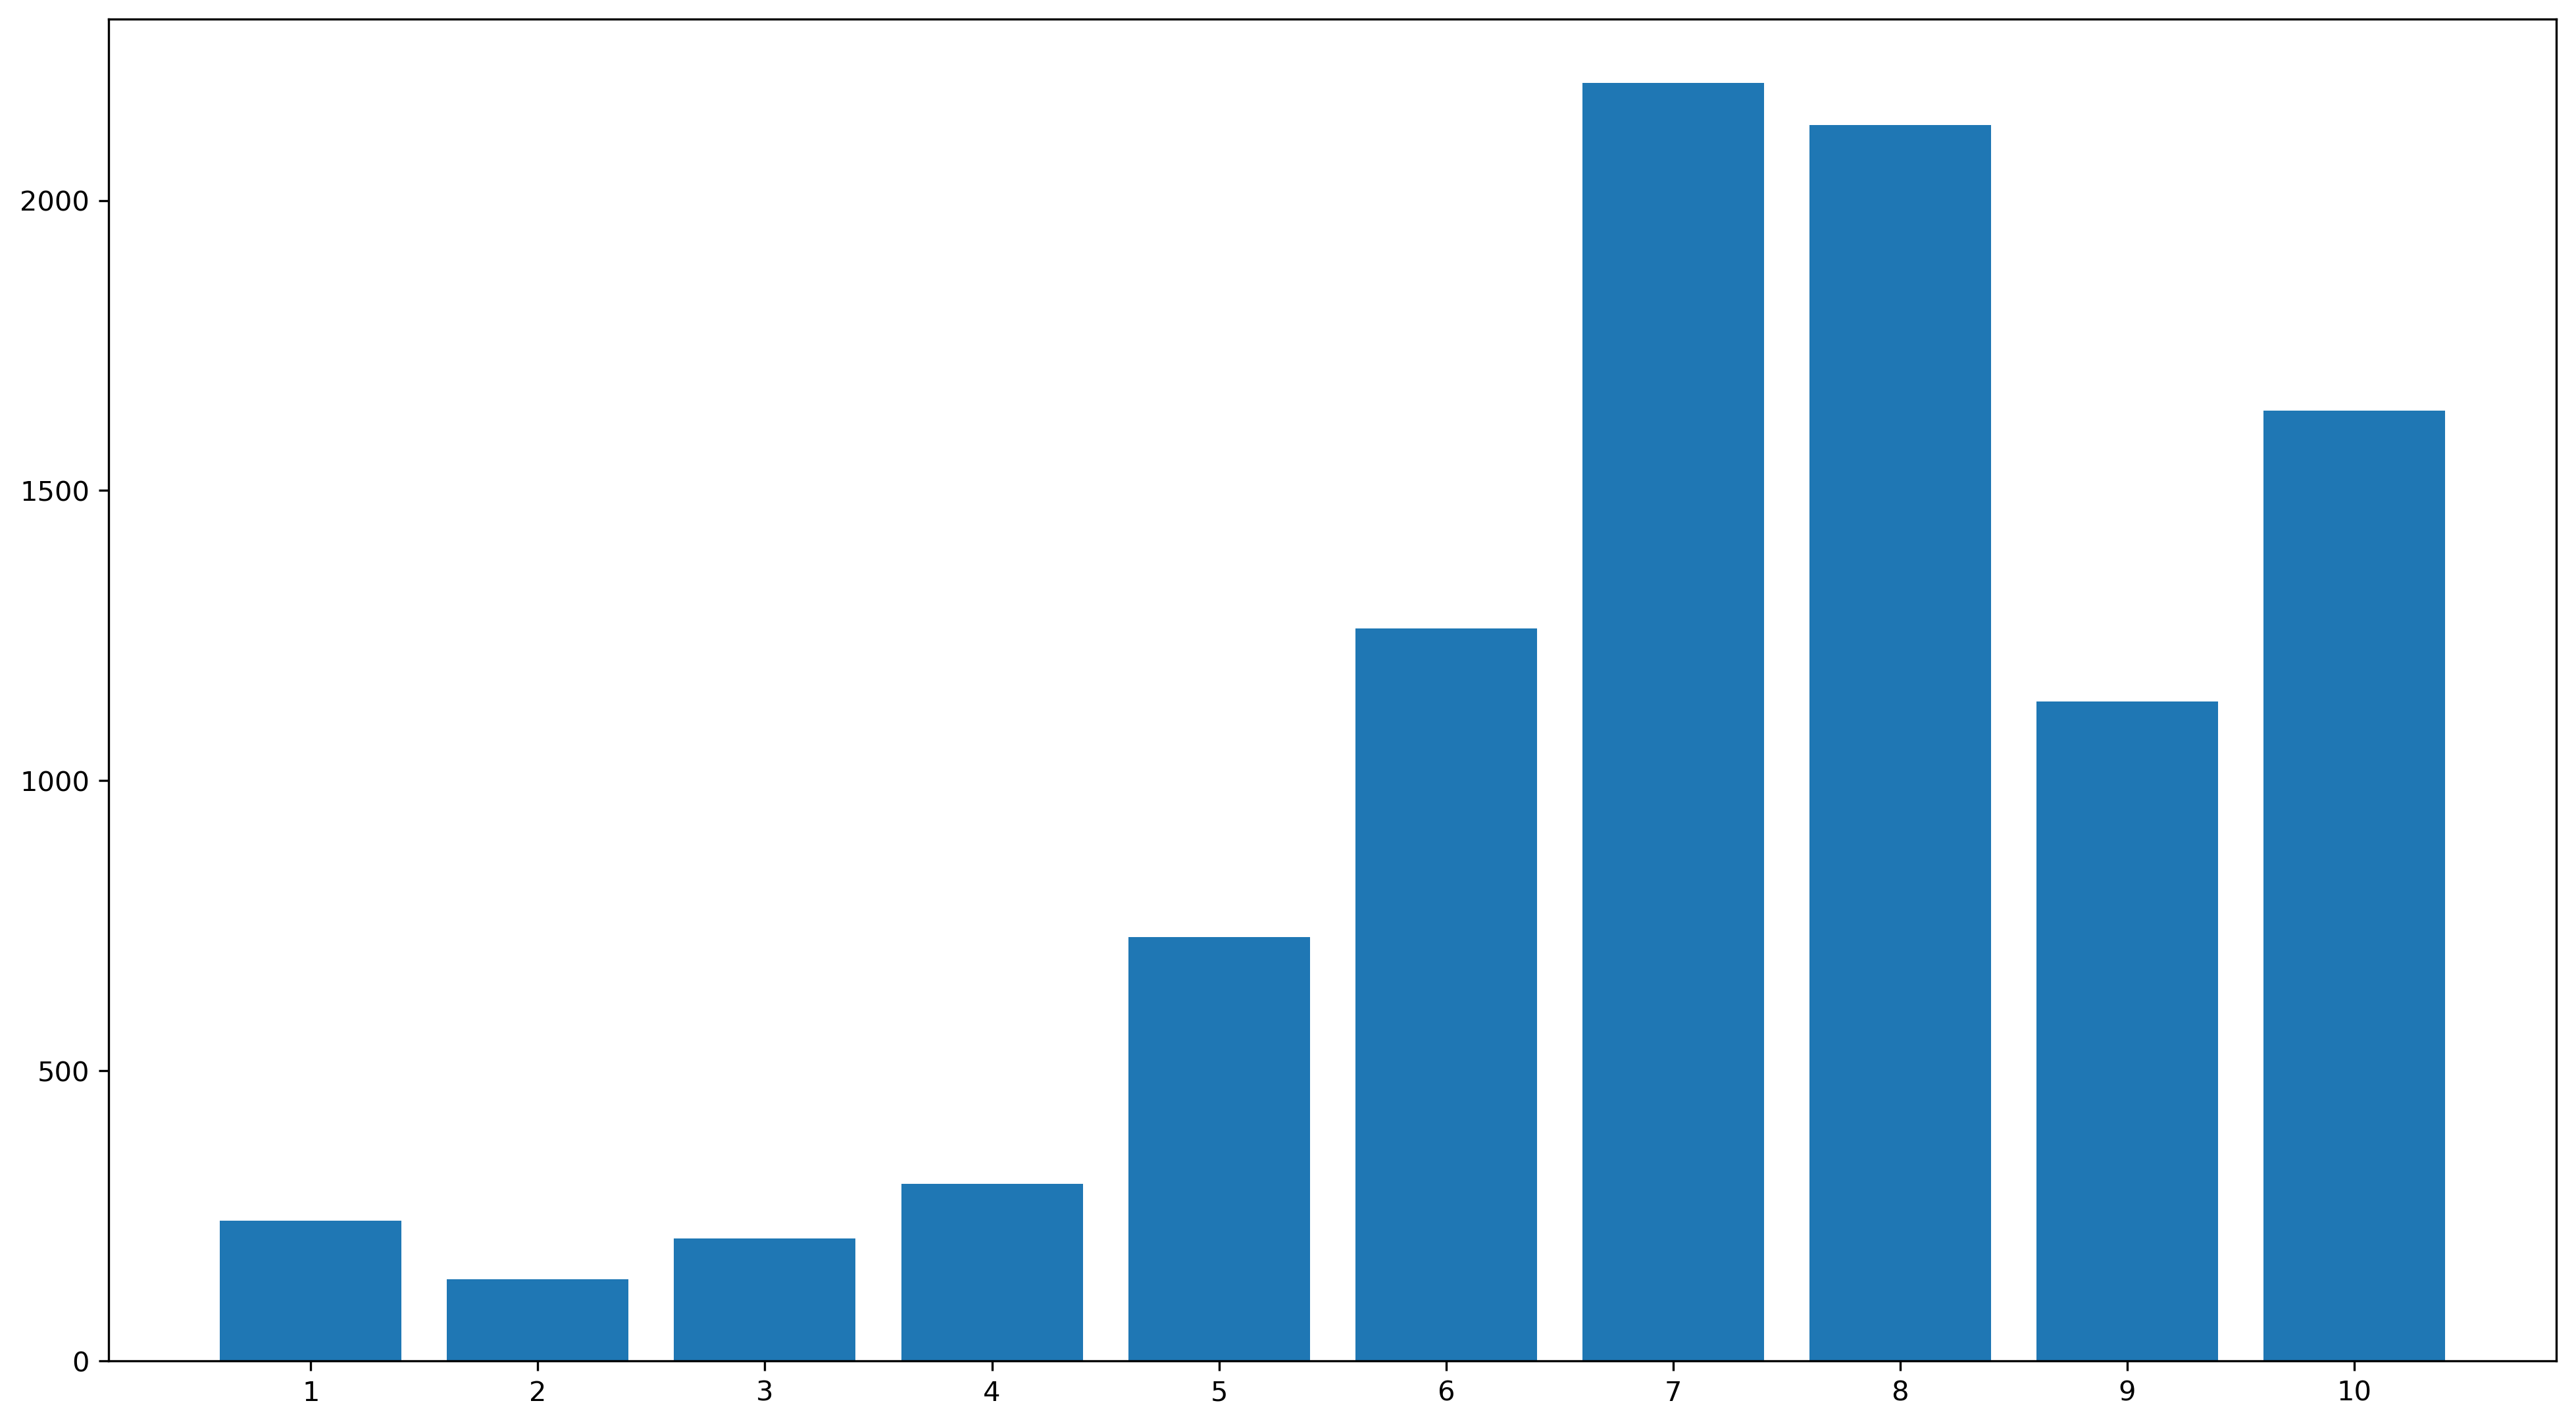

In [26]:
# множественное присваивание, subplots() возвращает сразу 2 элемента

fig, ax = plt.subplots(figsize = (16, 9), dpi = 300) 
ax.bar(df["title"], df["value"])

Неформально, создавая `fig` мы резервируем место под картинку соответствующего размера, а затем проводим различные манипуляции с `ax`, чтобы внутри этого поля для картинки построить график, настроить подписи, оси и прочее. Соответственно, к `ax` мы будем применять различные методы, а по завершении работы сможем выгрузить объект `fig` в файл PNG или JPEG. Вообще функция `subplots()`, как следует из ее названия, может использоваться для построения сразу нескольких графиков, но у нас пока внутри `fig` будет один.

Добавим сетку на график и зафиксируем, чтобы она не накладывалась поверх столбиков (`set_axisbelow()`):

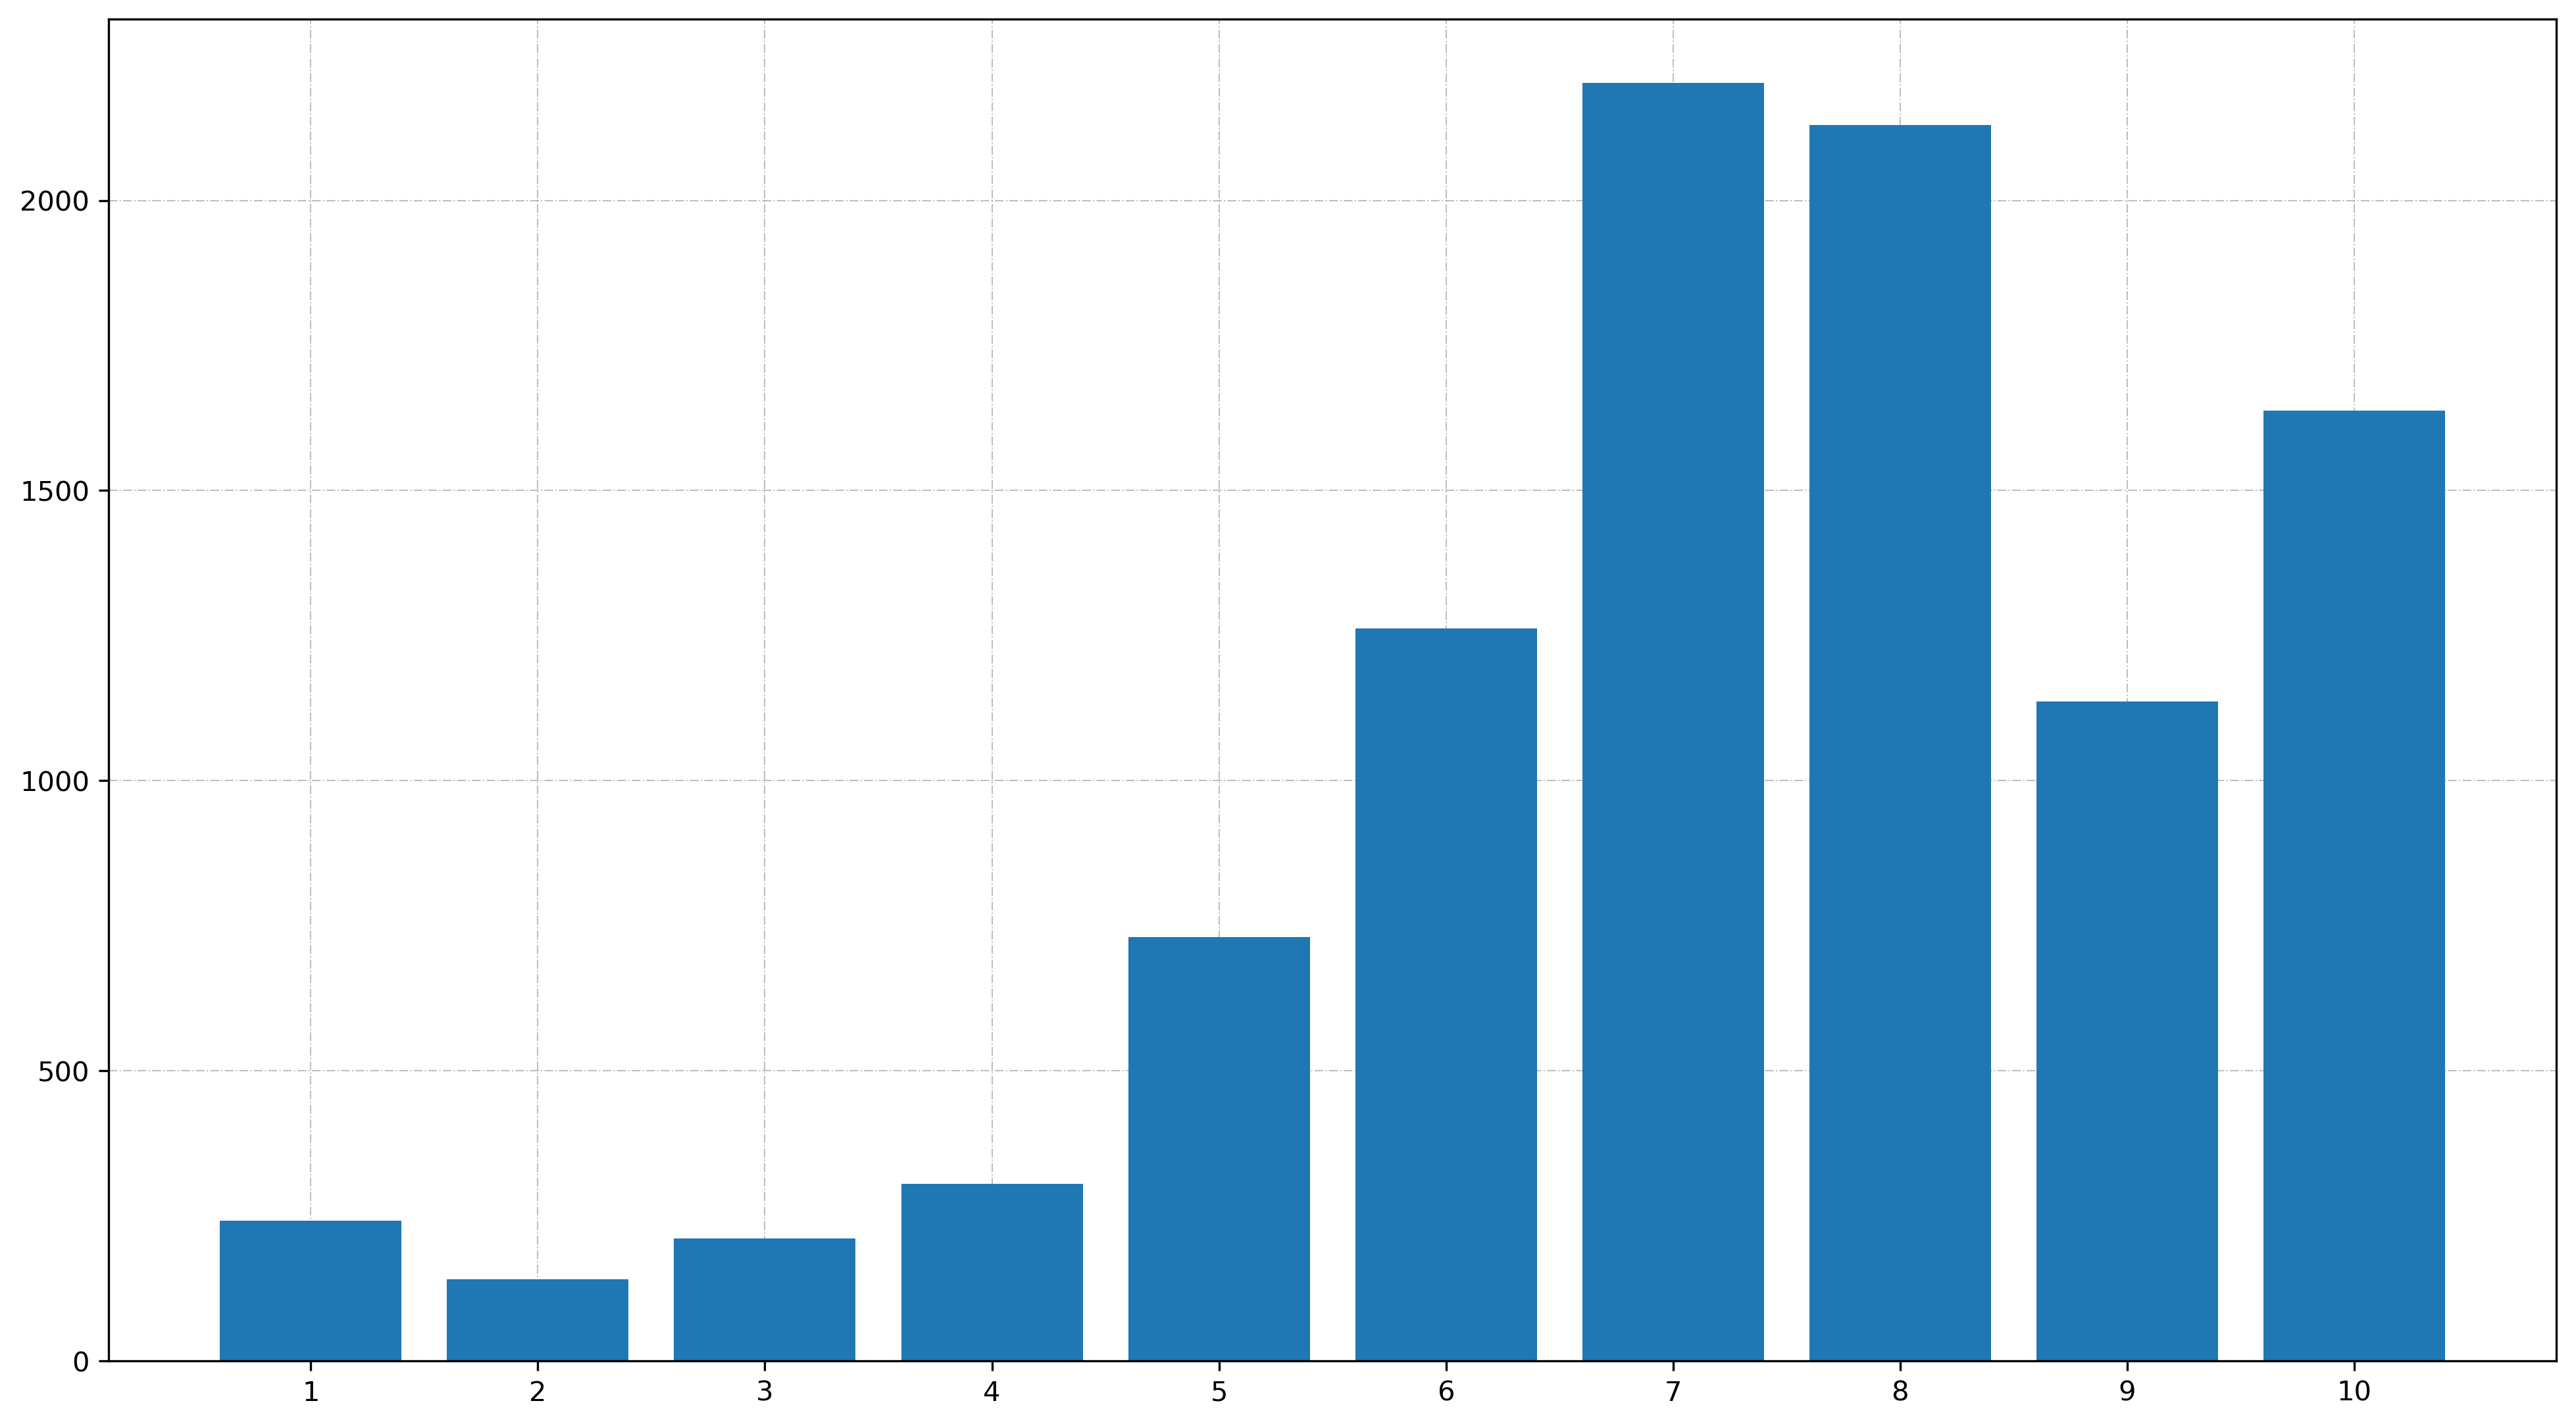

In [27]:
fig, ax = plt.subplots(figsize = (16, 9), dpi = 300) 

ax.bar(df["title"], df["value"])

# color – цвет сетки
# linestyle – тип линии
# linewidth – толщина линии
# alpha – прозрачность

ax.set_axisbelow(True)
ax.grid(b = True, color ='grey', linestyle = '-.', 
        linewidth = 0.5, alpha = 0.5);

Изменим цвета столбцов – создадим список, предполагая, что оценки от 1 до 3 должны быть отмечены темно-красным, оценки 4-5 – темно-оранжевым, оценки 6-7 – золотым и оценки 8-10 – темно-зеленым:

In [28]:
# список цветов

cols = ["darkred"] * 3 + ["darkorange"] * 2 + ["gold"] * 2 + ["darkcyan"] * 3
cols

['darkred',
 'darkred',
 'darkred',
 'darkorange',
 'darkorange',
 'gold',
 'gold',
 'darkcyan',
 'darkcyan',
 'darkcyan']

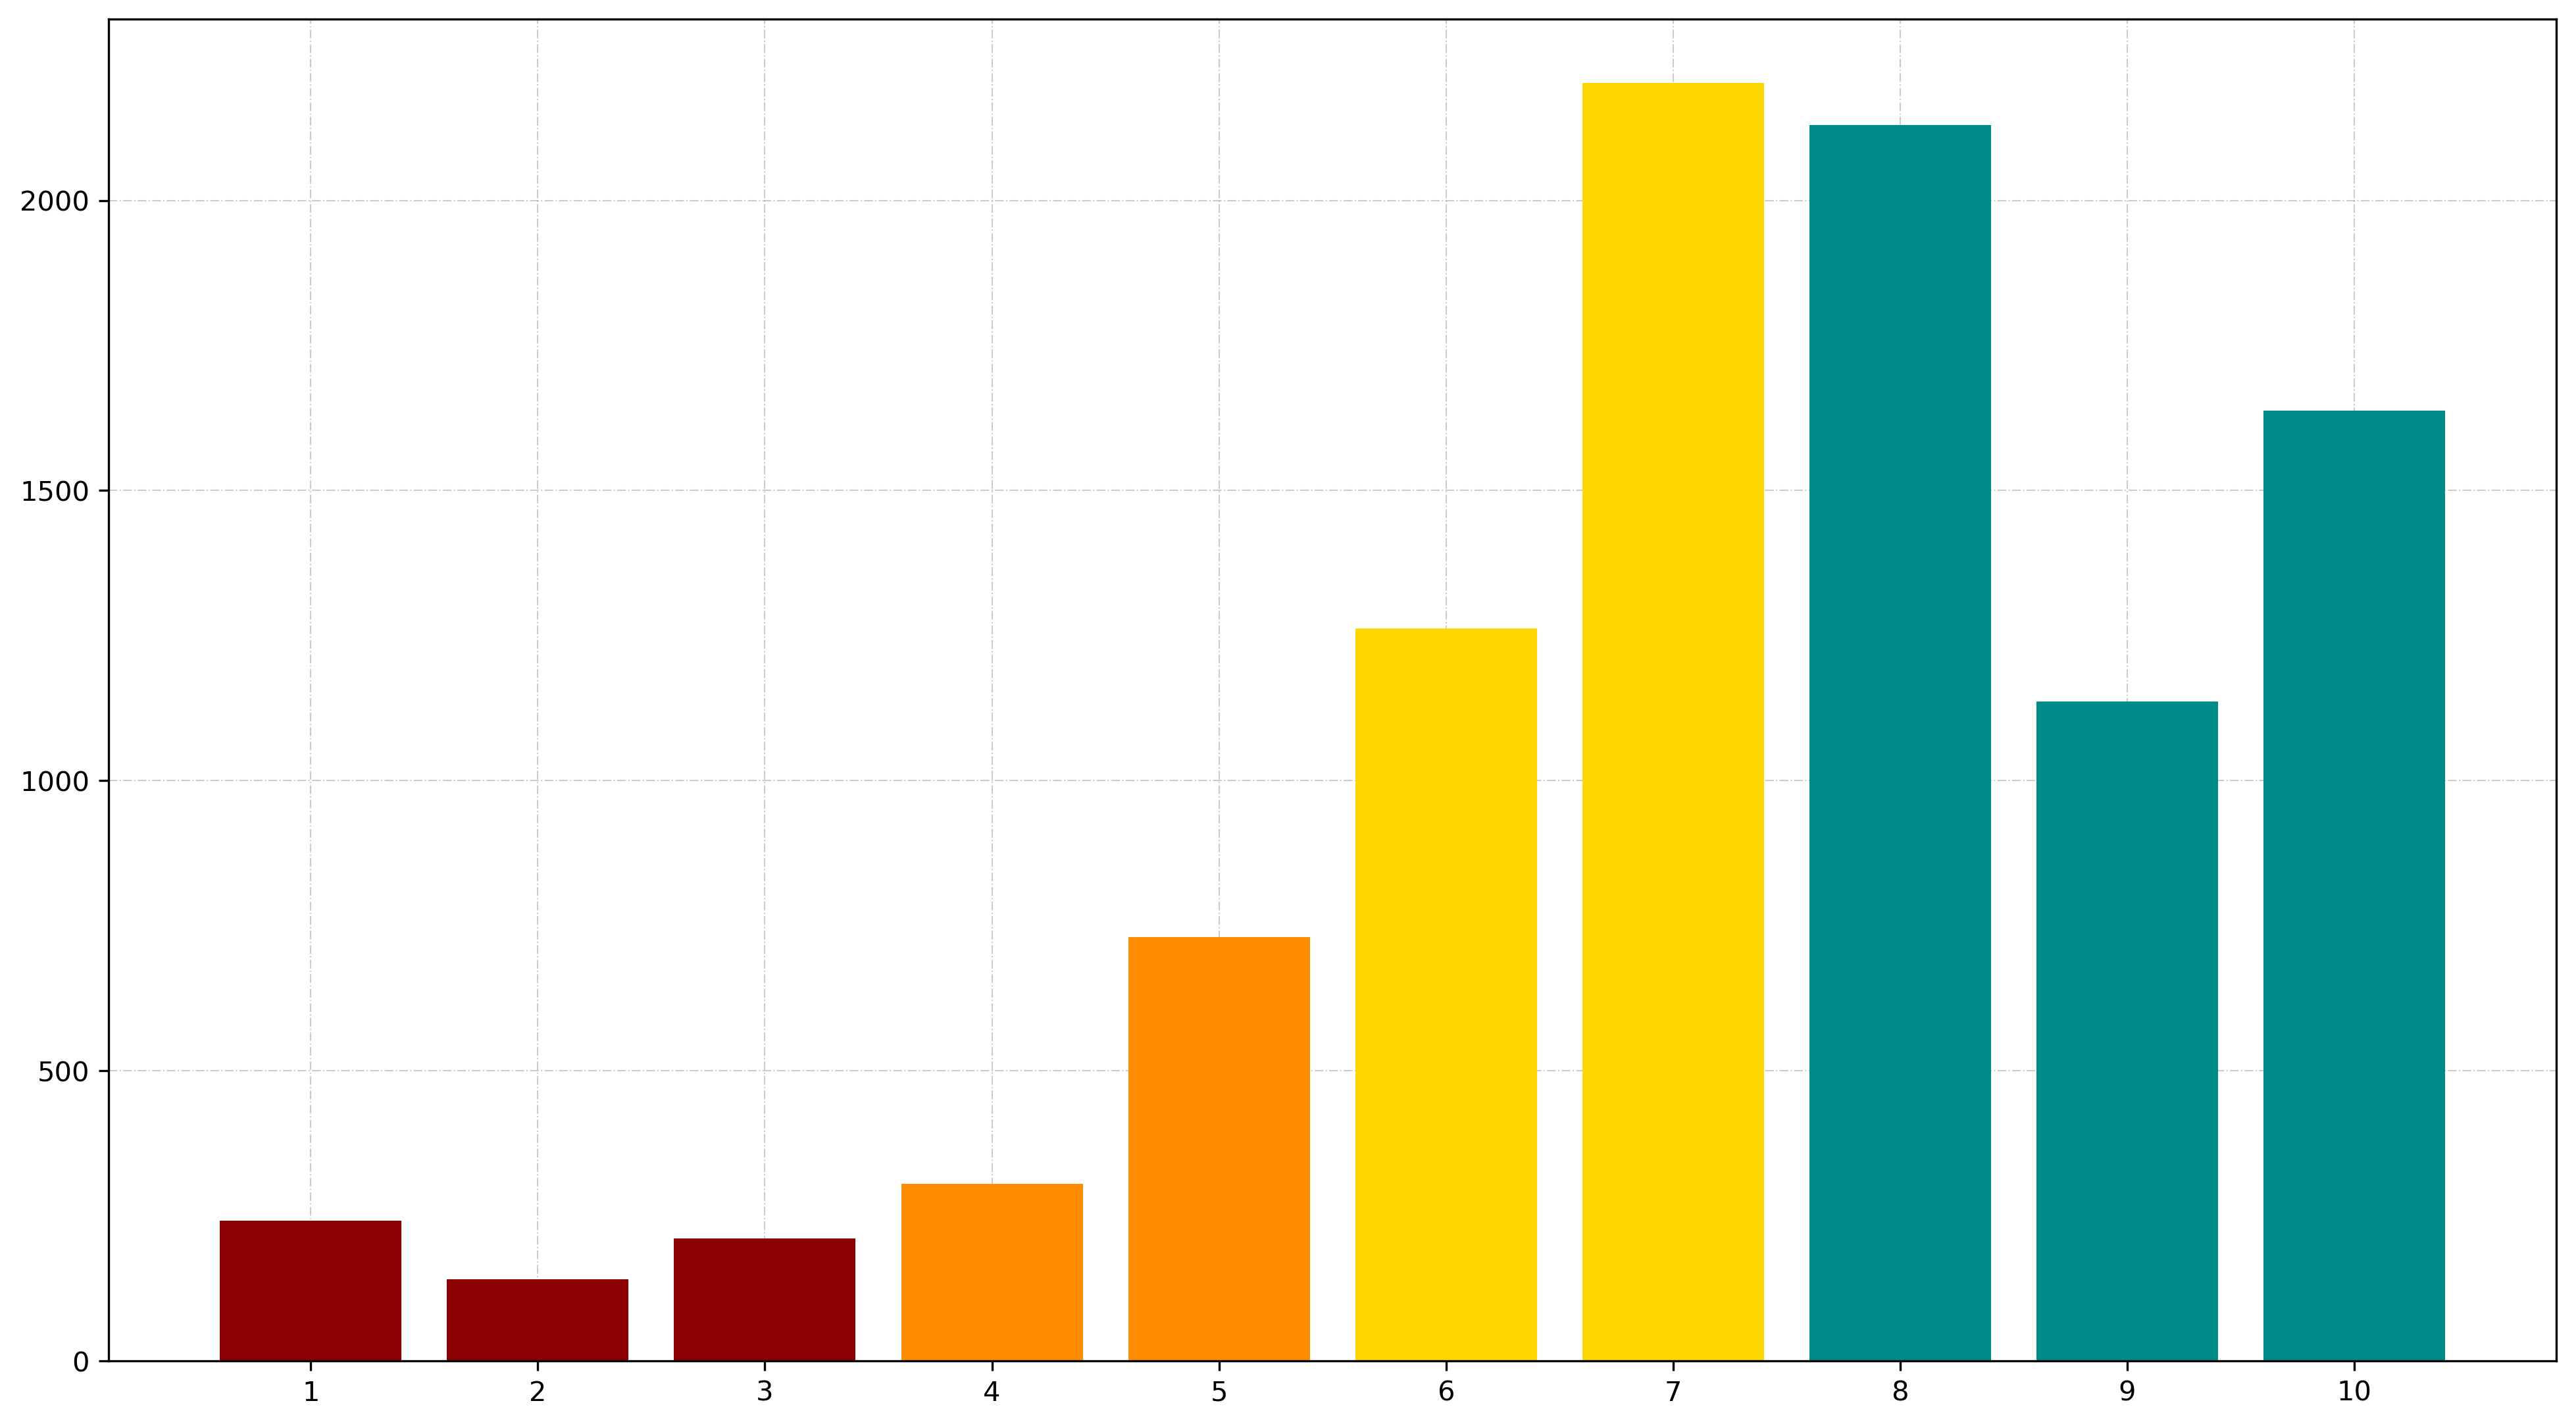

In [29]:
fig, ax = plt.subplots(figsize = (16, 9), dpi = 300) 

ax.bar(df["title"], df["value"], color = cols)
ax.set_axisbelow(True)
ax.grid(b = True, color ='grey', linestyle = '-.', 
        linewidth = 0.5, alpha = 0.4);

Цвета, конечно, пока не очень, но вдля начала неплохо :)

График можно сохранить – выгрузить в файл:

In [31]:
fig.savefig("ratings.png")